#Libraries and Packages

In [2]:
!pip install python-geohash
!pip install pygeohash
!pip install fastdtw

  Preparing metadata (setup.py) ... done
  Created wheel for python-geohash: filename=python_geohash-0.8.5-cp311-cp311-linux_x86_64.whl size=41946 sha256=9f138e67a7df72933b5e88137556fcac7707793031a1237b4fad4826a7d23186
  Stored in directory: /root/.cache/pip/wheels/02/7a/f4/c27d535af1a4ad8c1112e1bf299d9d47b57fe0fa2a464e4795
Successfully built python-geohash
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp311-cp311-linux_x86_64.whl size=542101 sha256=48ab5c80957a990e63c225c59e9b67d2beb3b6c625ffff70232ce2619ee208f3
  Stored in directory: /root/.cache/pip/wheels/5c/8a/f6/fd3df9a9714677410a5ccbf3ca519e66db4a54a1c46ea95332
Successfully built fastdtw


In [3]:
import pandas as pd
import numpy as np
from branca.element import Element
from folium.plugins import MousePosition, MiniMap
from folium.features import DivIcon
from folium import LayerControl
import os
import json
import pyarrow.parquet as pq
from collections import defaultdict
from google.colab  import drive
from datetime import datetime, timedelta
import folium
from folium.plugins import MarkerCluster
from collections import defaultdict
from folium.plugins import HeatMap
import joblib
import math, bisect, random
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
import pdb
from tqdm import tqdm
from dateutil.relativedelta import relativedelta
from pathlib import Path
from itertools import combinations
import geohash
import networkx as nx
import matplotlib.pyplot as plt
import scipy.signal as signal
import hashlib
from networkx.algorithms.community import greedy_modularity_communities, modularity
import itertools
import pygeohash as pgh
import math, random, numpy as np, pandas as pd
from itertools import combinations
from tqdm import tqdm
from fastdtw import fastdtw
from numba import njit, prange
from numba.typed import List as NbList

In [5]:
drive.mount('/content/drive')
myDriveFile = "/content/drive/MyDrive/CLIMATOY/"

Mounted at /content/drive


In [6]:
# Define the starting month of the whole project. 2022-08-01 to 2023-07-31
original_date=datetime(2022, 8, 1)


# Define the pre disaster date range
start_date = datetime(2022, 8, 1)
end_date = datetime(2022, 7, 31)

# 1. Filter Holiday records from 2019-12-24 18:00 to 22:00
start_time = pd.Timestamp("2022-12-24 18:00:00")
end_time   = pd.Timestamp("2022-12-24 22:00:00")
# start_time = pd.Timestamp("2020-01-01 18:00:00")
# end_time   = pd.Timestamp("2020-01-01 22:00:00")

# Base path
myDriveFile = "/content/drive/MyDrive/CLIMATOY/"
base_path = myDriveFile + 'toy datasets/'

# Define the bounding box for Florida
min_lat, max_lat = 26.490448860026532, 26.604200914701607
min_lon, max_lon = -82.04150698533131, -81.87502336164845

# Baltimore
# min_lat, max_lat = 39.20, 39.40
# min_lon, max_lon = -76.72, -76.50

# NYC
# min_lat, max_lat = 40.4774, 40.9176
# min_lon, max_lon = -74.2591, -73.7004

# # #  bounding box for Longisland
# min_lat, max_lat = 40.55, 41.05
# min_lon, max_lon = -73.95, -71.85

# A small county in the middle of Long Island
# min_lat, max_lat = 40.75, 40.85
# min_lon, max_lon = -73.05, -72.85

# somewhere in Maryland
min_lat = 39.1550
max_lat = 	39.2450
min_lon = -77.3081
max_lon = -77.1919

# # Region around Brookhaven and Mastic Beach
# min_lat = 40.728352567124034
# max_lat = 40.82784572793889
# min_lon = -72.95011028894201
# max_lon = -72.72004468171392



def hash_user_id(user_id):
    return hashlib.sha256(str(user_id).encode()).hexdigest()[:10]


# Data Pre-processing

In [ ]:
#Loading Data and do filtering based on study region


dfs = []

current_date = start_date
while current_date <= end_date:
    date_str = current_date.strftime('%Y%m%d')
    parquet_file_path = f"{base_path}{date_str}/"

    try:
        print(f"Reading data for {date_str}...")
        df_temp = pd.read_parquet(parquet_file_path, engine='pyarrow')

        # Add a date column to keep track of the source date (optional)
        df_temp['source_date'] = date_str
        dfs.append(df_temp)
        print(f"Successfully read data with shape: {df_temp.shape}")

    except Exception as e:
        print(f"Error reading data for {date_str}: {e}")

    current_date += timedelta(days=1)

# Check if we have any dataframes to concatenate
if len(dfs) > 0:
    combined_df = pd.concat(dfs, ignore_index=True)
    print("\nCombined Dataframe Info:")
    print(f"Shape: {combined_df.shape}")
    print(f"Column Names: {combined_df.columns.tolist()}")
    print("\nFirst 5 rows of combined data:")
    print(combined_df.head(5))

    combined_df.to_parquet(myDriveFile+"combined_data.parquet")
else:
    print("No data was read successfully.")

In [7]:
parquet_file_path = myDriveFile + "combined_data.parquet"
combined_df = pd.read_parquet(parquet_file_path, engine='pyarrow')

# Filter rows based on the bounding box
filtered_df = combined_df[
    (combined_df["latitude_2"] >= min_lat) & (combined_df["latitude_2"] <= max_lat) |
    (combined_df["longitude_2"] >= min_lon) & (combined_df["longitude_2"] <= max_lon)
]

print(f"Original DataFrame shape: {combined_df.shape}")
print(f"Filtered DataFrame shape: {filtered_df.shape}")
print(f"Filtered {combined_df.shape[0] - filtered_df.shape[0]} rows")

# output_path = myDriveFile + "filtered_florida_data.parquet"
# filtered_df.to_parquet(output_path)
# print(f"Saved filtered data to {output_path}")

# # If you also want a CSV version
# csv_output_path = myDriveFile + "filtered_florida_data.csv"
# filtered_df.to_csv(csv_output_path, sep="\t", index=False)
# print(f"Also saved as CSV to {csv_output_path}")

Original DataFrame shape: (5361762, 30)
Filtered DataFrame shape: (1700081, 30)
Filtered 3661681 rows


In [8]:
geohash_1_list = []
geohash_2_list = []

for lat1, lon1, lat2, lon2 in zip(
    filtered_df["latitude_1"], filtered_df["longitude_1"],
    filtered_df["latitude_2"], filtered_df["longitude_2"]
):
    geohash_1_list.append(geohash.encode(lat1, lon1, precision=9))
    geohash_2_list.append(geohash.encode(lat2, lon2, precision=9))

filtered_df["geohash_1"] = geohash_1_list
filtered_df["geohash_2"] = geohash_2_list


# Keep only the specified columns
columns_to_keep = [
    'device_id',
    'linked_trip_id',
    'utc_timestamp_1',
    'utc_offset_1',
    'utc_timestamp_2',
    'utc_offset_2',
    'latitude_1',
    'longitude_1',
    'geohash_1',
    'latitude_2',
    'longitude_2',
    'geohash_2'
]
filtered_df = filtered_df[columns_to_keep]

# Create unix_time columns (adding offset to timestamps)
filtered_df['unix_time_1'] = filtered_df['utc_timestamp_1'] + filtered_df['utc_offset_1']
filtered_df['unix_time_2'] = filtered_df['utc_timestamp_2'] + filtered_df['utc_offset_2']

# Generate human-readable timestamps
def unix_to_mdy_hms(unix_time):
    return datetime.fromtimestamp(unix_time).strftime('%m/%d/%Y %H:%M:%S')

filtered_df['timestamp_1'] = filtered_df['unix_time_1'].apply(unix_to_mdy_hms)
filtered_df['timestamp_2'] = filtered_df['unix_time_2'].apply(unix_to_mdy_hms)

# Add original_device_id column (ground truth)
filtered_df['original_device_id'] = filtered_df['device_id']

# Convert timestamps to datetime for date operations
filtered_df['datetime_1'] = pd.to_datetime(filtered_df['timestamp_1'])
filtered_df['date_1'] = filtered_df['datetime_1'].dt.date

# Hash coding
filtered_df['device_id']=filtered_df['device_id'].apply(hash_user_id)

# Get the total number of unique device_ids
all_device_ids = filtered_df['device_id'].unique()
total_device_ids = len(all_device_ids)
print(len(filtered_df))
print(total_device_ids)

<ipython-input-8-eb752a8c70f3>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["geohash_1"] = geohash_1_list
<ipython-input-8-eb752a8c70f3>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df["geohash_2"] = geohash_2_list
<ipython-input-8-eb752a8c70f3>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable

1700081
70087


#Shuffling and Deshuffling

In [13]:
def link_device_trajectories_optimized(df, max_time_gap_seconds=3600, geohash_digit_tolerance=8):
    """
    Links device trajectories based on temporal proximity and geohash similarity.
    When a device ID disappears, finds the new device ID with the closest geohash match within the specified time window.
    Also handles the case of device ID shuffling:
      1. Before the function starts, it reads a JSON file (default: device_id_shuffle_map.json).
         If a device_id in df is found in this mapping (i.e., it's a new ID), it will be replaced with its original ID.
      2. During the linking process, if a device ID link is detected (i.e., original ID differs from new ID),
         the new-to-original ID pair will be added to the JSON mapping file.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing trajectory data with device_id, unix_time_1,
        unix_time_2, geohash_1, geohash_2
    max_time_gap_seconds : int
        Maximum allowed time gap between trajectories to be linked (in seconds)
    geohash_digit_tolerance : int
        Minimum number of matching digits required in geohash comparison

    Returns:
    --------
    pandas.DataFrame
        DataFrame with linked device IDs
    dict
        Mapping of device IDs that were linked
    """
    import numpy as np
    from collections import defaultdict
    import os
    import json

    # --- New: Load original-to-shuffled ID mapping from JSON and replace new IDs in df ---
    shuffle_file = "device_id_shuffle_map.json"
    if os.path.exists(shuffle_file):
        with open(shuffle_file, 'r') as f:
            shuffle_mapping = json.load(f)
        print(f"Loaded existing shuffle mapping from {shuffle_file}.")
    else:
        shuffle_mapping = {}
        print(f"No existing shuffle mapping found. Starting with an empty mapping.")

    # Replace new device IDs in df with original IDs using the loaded mapping
    df['device_id'] = df['device_id'].apply(lambda x: shuffle_mapping.get(x, x))

    # -----------------------------------------------------------------------------------

    print("Starting trajectory linking process...")
    print(f"Parameters: max_time_gap={max_time_gap_seconds}s, geohash_digits={geohash_digit_tolerance}")

    linked_df = df.copy()
    linked_df = linked_df.sort_values(['device_id', 'unix_time_1'])

    device_groups = linked_df.groupby('device_id')

    device_last_points = {}
    for device_id, group in device_groups:
        last_row = group.loc[group['unix_time_2'].idxmax()]
        device_last_points[device_id] = {
            'time': last_row['unix_time_2'],
            'geohash': last_row['geohash_2'],
            'last_seen_idx': last_row.name
        }

    device_first_points = {}
    for device_id, group in device_groups:
        first_row = group.loc[group['unix_time_1'].idxmin()]
        device_first_points[device_id] = {
            'time': first_row['unix_time_1'],
            'geohash': first_row['geohash_1'],
            'first_seen_idx': first_row.name
        }

    print(f"Identified last points for {len(device_last_points)} device IDs")
    print(f"Identified first points for {len(device_first_points)} device IDs")

    geohash_similarity_cache = {}
    def geohash_similarity(geohash1, geohash2):
        cache_key = (geohash1, geohash2)
        if cache_key in geohash_similarity_cache:
            return geohash_similarity_cache[cache_key]

        min_len = min(len(geohash1), len(geohash2))
        for i in range(min_len):
            if geohash1[i] != geohash2[i]:
                result = i
                geohash_similarity_cache[cache_key] = result
                return result
        result = min_len
        geohash_similarity_cache[cache_key] = result
        return result

    time_buckets = defaultdict(list)
    for device_id, first_point in device_first_points.items():
        time_bucket = first_point['time'] // max_time_gap_seconds
        time_buckets[time_bucket].append((device_id, first_point))

    linked_device_pairs = []
    unlinked_device_count = 0
    already_linked_new_devices = set()

    for device_id, last_point in device_last_points.items():
        last_time_bucket = last_point['time'] // max_time_gap_seconds
        relevant_buckets = [last_time_bucket, last_time_bucket + 1]

        best_match = None
        best_similarity = -1

        for bucket in relevant_buckets:
            if bucket not in time_buckets:
                continue

            for new_device_id, first_point in time_buckets[bucket]:
                if (new_device_id == device_id or
                    first_point['time'] <= last_point['time'] or
                    new_device_id in already_linked_new_devices):
                    continue

                time_diff = first_point['time'] - last_point['time']
                if time_diff > max_time_gap_seconds:
                    continue

                similarity = geohash_similarity(last_point['geohash'], first_point['geohash'])
                if similarity >= geohash_digit_tolerance and similarity > best_similarity:
                    best_match = new_device_id
                    best_similarity = similarity

        if best_match:
            linked_device_pairs.append((device_id, best_match))
            already_linked_new_devices.add(best_match)
        else:
            unlinked_device_count += 1

    print(f"Found {len(linked_device_pairs)} potential device links")
    print(f"Could not find suitable matches for {unlinked_device_count} device IDs")

    device_id_mapping = {}
    def find_root_device(device_id):
        path = []
        current = device_id
        while current in device_id_mapping:
            path.append(current)
            current = device_id_mapping[current]
        for node in path:
            device_id_mapping[node] = current
        return current

    for old_id, new_id in linked_device_pairs:
        device_id_mapping[new_id] = old_id

    all_device_ids = set(linked_df['device_id'].unique())
    root_mapping = {device_id: find_root_device(device_id) for device_id in all_device_ids}

    linked_df['linked_device_id'] = linked_df['device_id'].map(root_mapping).fillna(linked_df['device_id'])

    print("Trajectory linking completed")

    # --- New: Update JSON mapping file ---
    # For all new-to-original mappings where IDs differ, update shuffle_mapping
    for new_id, original_id in device_id_mapping.items():
        if new_id != original_id and new_id not in shuffle_mapping:
            shuffle_mapping[new_id] = original_id
    with open(shuffle_file, 'w') as f:
        json.dump(shuffle_mapping, f, indent=4)
    print(f"Updated shuffle mapping written to {shuffle_file}.")
    # -----------------------------------------------------------------------------------

    return linked_df, device_id_mapping


In [14]:
def apply_residency_filter(df, min_lat, max_lat, min_lon, max_lon):

    in_box = (
        df['latitude_2'].between(min_lat, max_lat) &
        df['longitude_2'].between(min_lon, max_lon)
    )

    total_counts   = df['device_id'].value_counts()
    in_box_counts  = df[in_box]['device_id'].value_counts()

    stats = (
        pd.DataFrame({
            'total':   total_counts,
            'in_box':  in_box_counts
        })
        .fillna(0)
    )

    valid_devices = stats[ stats['in_box'] >= stats['total'] / 2].index

    return df[ df['device_id'].isin(valid_devices) ].copy()

def apply_residency_filter2(df, min_appearances=30):
    device_counts = df['device_id'].value_counts()

    valid_devices = device_counts[device_counts >= min_appearances].index
    filtered_df = df[df['device_id'].isin(valid_devices)].copy()

    return filtered_df

In [15]:
filtered_df = apply_residency_filter(filtered_df, min_lat, max_lat, min_lon, max_lon)

filtered_df = apply_residency_filter2(filtered_df)
print(len(filtered_df))

496566


In [16]:
linked_df, _ = link_device_trajectories_optimized(
    filtered_df,
    max_time_gap_seconds=3600,
    geohash_digit_tolerance=8
)


Loaded existing shuffle mapping from device_id_shuffle_map.json.
Starting trajectory linking process...
Parameters: max_time_gap=3600s, geohash_digits=8
Identified last points for 6280 device IDs
Identified first points for 6280 device IDs
Found 0 potential device links
Could not find suitable matches for 6280 device IDs
Trajectory linking completed
Updated shuffle mapping written to device_id_shuffle_map.json.


#Residency Detection and Home Address Detection

In [19]:
def identify_home_locations(df, min_appearances=90, night_start_hour=23, night_end_hour=5,
                            min_home_visits=10, location_precision=4, w1=0.6, w2=0.4):
    """
    Identify home locations for each device using (primarily) night-time visits.
    If a device has *no* night-time data, its day-time data are used instead.
    """
    result_df = df.copy()

    # --- 1. Preprocessing ----------------------------------------------------------
    if not pd.api.types.is_datetime64_any_dtype(result_df['timestamp_2']):
        result_df['timestamp_2'] = pd.to_datetime(result_df['timestamp_2'])

    # Keep only devices with sufficient appearances
    device_counts = result_df['device_id'].value_counts()
    valid_devices = device_counts[device_counts >= min_appearances].index
    result_df = result_df[result_df['device_id'].isin(valid_devices)]

    # Round lat/lon to given precision as spatial cell
    result_df['location_cell'] = (
        result_df['latitude_2'].round(location_precision).astype(str) + '_' +
        result_df['longitude_2'].round(location_precision).astype(str)
    )

    # Extract hour and date from timestamp
    result_df['hour'] = result_df['timestamp_2'].dt.hour
    result_df['date'] = result_df['timestamp_2'].dt.date

    # --- 2. Keep only night-time visits --------------------------------------------
    if night_start_hour > night_end_hour:  # Crosses midnight
        night_mask = (result_df['hour'] >= night_start_hour) | (result_df['hour'] < night_end_hour)
    else:  # Does not cross midnight
        night_mask = (result_df['hour'] >= night_start_hour) & (result_df['hour'] < night_end_hour)

    night_visits = result_df[night_mask].copy()

    # Find devices without any night-time visits → use their daytime data as fallback
    all_devices = set(result_df['device_id'].unique())
    night_devices = set(night_visits['device_id'].unique())
    devices_no_night = all_devices - night_devices


    if devices_no_night:
        backup_visits = result_df[result_df['device_id'].isin(devices_no_night)].copy()
        night_visits = pd.concat([night_visits, backup_visits], ignore_index=True)

    # --- 3. Count visits per location per device -----------------------------------
    visit_counts = (
        night_visits
        .groupby(['device_id', 'location_cell'])
        .size()
        .reset_index(name='visits')
    )

    home_candidates = visit_counts[visit_counts['visits'] >= min_home_visits].copy()

    # If a device has no location reaching the threshold → choose most visited location
    missing_dev = all_devices - set(home_candidates['device_id'].unique())
    if missing_dev:
        fallback = (
            visit_counts[visit_counts['device_id'].isin(missing_dev)]
            .sort_values(['device_id', 'visits'], ascending=[True, False])
            .groupby('device_id')
            .head(1)
        )
        home_candidates = pd.concat([home_candidates, fallback], ignore_index=True)

    # --- 4. Compute temporal consistency -------------------------------------------
    distinct_days = (
        night_visits
        .groupby(['device_id', 'location_cell'])['date']
        .nunique()
        .reset_index(name='distinct_days')
    )
    total_days = max((result_df['date'].max() - result_df['date'].min()).days + 1, 1)

    home_candidates = home_candidates.merge(distinct_days, on=['device_id', 'location_cell'], how='left')
    home_candidates['distinct_days'] = home_candidates['distinct_days'].fillna(1)
    home_candidates['temporal_consistency'] = home_candidates['distinct_days'] / total_days

    # --- 5. Compute weighted score (penalize daytime-only data) --------------------
    penalty_mask = home_candidates['device_id'].isin(devices_no_night)

    home_candidates['score'] = np.where(
        penalty_mask,
        w1 * home_candidates['visits'] * 0.5 + w2 * home_candidates['temporal_consistency'] * 0.5,
        w1 * home_candidates['visits']       + w2 * home_candidates['temporal_consistency']
    )

    # --- 6. Select the best-scored location for each device ------------------------
    best_locations = home_candidates.loc[
        home_candidates.groupby('device_id')['score'].idxmax()
    ][['device_id', 'location_cell', 'score']]

    # Retrieve original latitude and longitude of the selected location
    loc_samples = (
        night_visits
        .groupby(['device_id', 'location_cell'])
        .agg({'latitude_2': 'first', 'longitude_2': 'first'})
        .reset_index()
    )

    home_locations = best_locations.merge(loc_samples, on=['device_id', 'location_cell'])
    home_locations = home_locations.rename(
        columns={'latitude_2': 'home_latitude', 'longitude_2': 'home_longitude'}
    )[['device_id', 'home_latitude', 'home_longitude']]

    # --- 7. Merge home locations back to the original dataframe ---------------------
    result_df = result_df.merge(home_locations, on='device_id', how='left')
    result_df = result_df.drop(columns=['hour', 'date', 'location_cell'])

    return result_df

result_df_with_homes = identify_home_locations(linked_df)

# result_df_with_homes.to_csv("florida_results/Individual_device_list_with_home_address.csv", index=False)



In [21]:
# Assume your DataFrame is named result_df_with_homes
# It contains the following columns:
# device_id, linked_trip_id, latitude, longitude, timestamp, home_latitude, home_longitude

# 1. Encode home_latitude and home_longitude into a 9-character Geohash
result_df_with_homes["home_geohash_8"] = result_df_with_homes.apply(
    lambda row: geohash.encode(row["home_latitude"], row["home_longitude"], precision=8),
    axis=1
)

# 2. Decode the 9-character Geohash to the center point (lat, lon) of the grid
#    decode() returns a tuple (center_lat, center_lon)
result_df_with_homes["home_center"] = result_df_with_homes["home_geohash_8"].apply(geohash.decode)

# 3. Split the tuple into two columns: home_latitude_8, home_longitude_8
result_df_with_homes["home_latitude_8"] = result_df_with_homes["home_center"].apply(lambda x: x[0])
result_df_with_homes["home_longitude_8"] = result_df_with_homes["home_center"].apply(lambda x: x[1])

# 4. If the intermediate column home_center is no longer needed, delete it
result_df_with_homes.drop(columns=["home_center"], inplace=True)

# Select the columns to retain
cols_to_keep = ['device_id', 'home_latitude', 'home_longitude',
                'home_geohash_8', 'home_latitude_8', 'home_longitude_8']

# Extract these columns and remove duplicate device_id entries
result_df_subset = result_df_with_homes[cols_to_keep].copy().drop_duplicates(subset=['device_id'])

# home_latitude_8, home_longitude_8 are center coordinate of the grid cell by geohash, home_latitude, home_longitude are orginal home coordinate
# View the processed data
print(result_df_with_homes.head())
print("Number of home count:", result_df_subset['device_id'].nunique())
# result_df_subset.to_csv("all_household_list.csv", index=False)
# result_df_subset_save=result_df_subset[['device_id','home_geohash_8']]

last_month = start_date - relativedelta(months=1)
prev_path  = Path(f"florida_results/user_home_relation_{last_month.date()}.csv")

if prev_path.exists():
    prev_df = pd.read_csv(prev_path, dtype={'device_id': str, 'home_geohash_8': str})
    prev_df = prev_df[['device_id', 'home_geohash_8']].rename(columns={'home_geohash_8': 'prev_geohash_8'})

    # -------------------------------------------------
    # 1. Merge current and previous GeoHashes by device_id
    # -------------------------------------------------
    merged = result_df_subset.merge(prev_df, on='device_id', how='left')

    # -------------------------------------------------
    # 2. If first 6 chars match, keep previous 8-char GeoHash
    # -------------------------------------------------
    use_prev_mask = (
        merged['prev_geohash_8'].notna() &
        (merged['home_geohash_8'].str[:6] == merged['prev_geohash_8'].str[:6])
    )
    merged.loc[use_prev_mask, 'home_geohash_8'] = merged.loc[use_prev_mask, 'prev_geohash_8']

    # -------------------------------------------------
    # 3. Recompute centre lat/lon for any rows that just changed
    # -------------------------------------------------
    changed = merged['home_latitude_8'].isna() | use_prev_mask
    merged.loc[changed, ['home_latitude_8', 'home_longitude_8']] = (
        merged.loc[changed, 'home_geohash_8']
              .apply(lambda gh: pd.Series(geohash.decode(gh)))
              .values
    )

    # drop helper column & write out
    result_df_subset = merged.drop(columns='prev_geohash_8')
else:
    print(f"[WARN] Previous-month file not found: {prev_path}")

# -------------------------------------------------
# 4. Save the updated mapping for this month
# -------------------------------------------------
os.makedirs('florida_results', exist_ok=True)  # 如果目录不存在就创建

result_df_subset.to_csv(f"florida_results/user_home_relation_{start_date.date()}.csv", index=False)


    device_id                                     linked_trip_id  \
0  000fbea9f2  deb4ea7eaec47460778821bd03a70f304147f43a1cb066...   
1  000fbea9f2  deb4ea7eaec47460778821bd03a70f304147f43a1cb066...   
2  000fbea9f2  deb4ea7eaec47460778821bd03a70f304147f43a1cb066...   
3  000fbea9f2  deb4ea7eaec47460778821bd03a70f304147f43a1cb066...   
4  000fbea9f2  deb4ea7eaec47460778821bd03a70f304147f43a1cb066...   

   utc_timestamp_1  utc_offset_1  utc_timestamp_2  utc_offset_2  latitude_1  \
0       1577892334        -18000       1577896704        -18000   38.470078   
1       1577984248        -18000       1577985442        -18000   39.173393   
2       1577985825        -18000       1577986530        -18000   39.182507   
3       1578052447        -18000       1578053393        -18000   39.173954   
4       1578071487        -18000       1578071932        -18000   39.137108   

   longitude_1  geohash_1  latitude_2  ...         timestamp_2  \
0   -77.411743  dqbfy7q2r   39.172916  ... 2020-01

# POI+DTW method to construct individual network

In [22]:

# Suppose your new dataset is in a DataFrame called filtered_df,
# which has columns for two check-ins per row. We only want the second one.

# 1. Rename columns to match Gowalla style
#    user_id -> device_id or original_device_id (choose one)
#    timestamp -> timestamp_2
#    lat -> latitude_2
#    lon -> longitude_2
#    We'll unify them as: user_id, timestamp, lat, lon, poi (poi = geohash_2)

# renamed_df = filtered_df.rename(columns={
#     'device_id': 'user_id',        # or 'original_device_id' if preferred
#     'timestamp_2': 'timestamp',
#     'latitude_2': 'lat',
#     'longitude_2': 'lon'
# })

renamed_df = result_df_with_homes.rename(columns={
    'device_id': 'user_id',
    'timestamp_2': 'timestamp',
    'latitude_2': 'lat',
    'longitude_2': 'lon'
})

# 2. Convert the timestamp to the Gowalla-like format: YYYY-MM-DDTHH:MM:SSZ
renamed_df['timestamp'] = pd.to_datetime(renamed_df['timestamp'])
renamed_df['timestamp'] = renamed_df['timestamp'].dt.strftime('%Y-%m-%dT%H:%M:%SZ')

# 3. Compute 8-digit geohash as the new 'poi'
renamed_df['poi'] = renamed_df.apply(lambda row: pgh.encode(row['lat'], row['lon'], precision=9), axis=1)

# 4. Filter to keep only the relevant columns
columns_needed = ['user_id', 'timestamp', 'lat', 'lon', 'poi']
checkins = renamed_df[columns_needed].copy()


In [23]:
'''
Position of Interest (PoI) + Dynamic Time Warping (DTW) Type 1
'''

# Group by user_id and filter users with fewer than 10 check-ins



# -------------------------------------------------
# 0. Parameters
# -------------------------------------------------
min_trj_len = 90         # A user must have at least N check-ins to be considered active
topk        = 3           # Take the k smallest DTW values
radius      = 2           # Fast dtw allows ±2 steps of alignment shift. Set this value to bigger one will increase runningtime. Original DTW doesn't have this constraint.

# -------------------------------------------------
# 1. Data preparation (vectorized for speed and memory efficiency)
# -------------------------------------------------
checkins['timestamp'] = pd.to_datetime(checkins['timestamp'])
active_mask = checkins.groupby('user_id')['user_id'].transform('size') >= min_trj_len
checkins = checkins.loc[active_mask].copy()

# —— 1.1  Map PoI to index & coordinates —— #
uniq_poi = checkins.drop_duplicates('poi')[['poi', 'lat', 'lon']]
uniq_poi['idx'] = pd.factorize(uniq_poi['poi'])[0]
poi2idx   = dict(zip(uniq_poi['poi'], uniq_poi['idx']))
idx2coord = uniq_poi[['lat', 'lon']].to_numpy()        # shape (N,2)
checkins['poi_idx'] = checkins['poi'].map(poi2idx)     # int32

# —— 1.2  Get daily trajectories (as integer sequences) —— #
checkins['date'] = checkins['timestamp'].dt.date
user_daily_idx_py = (
    checkins.groupby(['user_id', 'date'])['poi_idx']
            .agg(list)
            .groupby(level=0).agg(list)
            .to_dict()                                  # {uid: [[idx...], ...]}
)

# —— 1.3  Convert to numba typed-list (required for JIT) —— #
def to_nb_list(days_py):
    nb_days = NbList()
    for day in days_py:
        nb_days.append(np.asarray(day, dtype=np.int32))
    return nb_days

user_daily_nb = {uid: to_nb_list(days) for uid, days in user_daily_idx_py.items()}

# —— 1.4  Candidate pairs (users sharing ≥1 PoI) —— #
user_all_pois = (
    checkins.groupby('user_id')['poi_idx']
            .agg(lambda s: set(s))
            .to_dict()
)
inv_index = (
    checkins.groupby('poi_idx')['user_id']
            .agg(lambda s: set(s))
)
candidate_pairs = set()
for users_set in inv_index:
    if len(users_set) > 1:
        candidate_pairs.update(combinations(sorted(users_set), 2))
candidate_pairs = list(candidate_pairs)
random.shuffle(candidate_pairs)

# -------------------------------------------------
# 2. Numba-JIT DTW (with Sakoe-Chiba window)
# -------------------------------------------------
lat_rad = np.radians(idx2coord[:, 0]).astype(np.float64)
lon_rad = np.radians(idx2coord[:, 1]).astype(np.float64)
R_EARTH = 6371.0

@njit(inline='always')
def haversine_idx(i, j, lat_r, lon_r):
    if i == j:
        return 0.0
    dlat = lat_r[j] - lat_r[i]
    dlon = lon_r[j] - lon_r[i]
    a = (math.sin(dlat * 0.5) ** 2 +
         math.cos(lat_r[i]) * math.cos(lat_r[j]) *
         math.sin(dlon * 0.5) ** 2)
    return 2.0 * R_EARTH * math.asin(math.sqrt(a))

@njit
def dtw_window(seq1, seq2, w, lat_r, lon_r):
    n, m = len(seq1), len(seq2)
    w    = max(w, abs(n - m))
    big  = 1e20
    dp   = np.full((n + 1, m + 1), big, dtype=np.float64)
    dp[0, 0] = 0.0

    for i in range(1, n + 1):
        j_lo = max(1, i - w)
        j_hi = min(m, i + w) + 1
        a_idx = seq1[i - 1]
        for j in range(j_lo, j_hi):
            b_idx = seq2[j - 1]
            cost  = haversine_idx(a_idx, b_idx, lat_r, lon_r)
            best  = dp[i - 1, j]
            if dp[i, j - 1] < best:
                best = dp[i, j - 1]
            if dp[i - 1, j - 1] < best:
                best = dp[i - 1, j - 1]
            dp[i, j] = cost + best

    # Backtrace to count path length
    i, j, path_len = n, m, 0
    while i or j:
        path_len += 1
        if i == 0:
            j -= 1
        elif j == 0:
            i -= 1
        else:
            a, b, c = dp[i - 1, j - 1], dp[i - 1, j], dp[i, j - 1]
            if a <= b and a <= c:
                i, j = i - 1, j - 1
            elif b < c:
                i -= 1
            else:
                j -= 1
    return dp[n, m] / path_len

@njit
def aggregate_topk(trajs_u, trajs_v, k, radius, lat_r, lon_r):
    tot = len(trajs_u) * len(trajs_v)
    dists = np.empty(tot, dtype=np.float32)
    p = 0
    for i in range(len(trajs_u)):
        for j in range(len(trajs_v)):
            dists[p] = dtw_window(trajs_u[i], trajs_v[j],
                                  radius, lat_r, lon_r)
            p += 1
    k = k if k < tot else tot
    for i in range(k):
        min_idx = i
        for j in range(i + 1, tot):
            if dists[j] < dists[min_idx]:
                min_idx = j
        dists[i], dists[min_idx] = dists[min_idx], dists[i]
    return dists[:k].mean()

# -------------------------------------------------
# 3. Compute DTW cost for all candidate pairs
# -------------------------------------------------
print("Fast-DTW running …")
candidate_costs = []
for (u, v) in tqdm(candidate_pairs):
    cost_uv = aggregate_topk(
        user_daily_nb[u],
        user_daily_nb[v],
        topk, radius, lat_rad, lon_rad
    )
    candidate_costs.append(cost_uv)

all_costs = np.array(candidate_costs, dtype=np.float32)


# 15% of the data will be positive
desired_ratio=0.3
# Sort the cost value
sorted_costs = np.sort(all_costs)
# Calculate place of the desired threshold
threshold_index = int(len(sorted_costs) * desired_ratio)
print(threshold_index)
fixed_threshold = sorted_costs[threshold_index]
print(f"Threshold selected: {fixed_threshold}")


# # Plot histogram of aggregated DTW costs to observe the distribution
# plt.figure()
# counts, bins, patches = plt.hist(all_costs, bins=100, alpha=0.7, color='skyblue', edgecolor='black')
# plt.xlabel('Aggregated DTW Cost')
# plt.ylabel('Frequency')
# plt.title('Distribution of Aggregated DTW Cost for Candidate Pairs')
# plt.show()


# 6. Predict social links based on threshold: candidate pairs with DTW cost < threshold are predicted as social links
predictions = [1 if cost <= fixed_threshold else 0 for cost in all_costs]
predictions = np.array(predictions)
print("Number of candidate pairs predicted as social links:", np.sum(predictions))



# Generate prediction results for candidate pairs based on the fixed threshold
dtw_results = []
scores=all_costs
for i, (u, v) in enumerate(candidate_pairs):
    score = scores[i]
    prediction = 1 if score <= fixed_threshold else 0
    dtw_results.append({
        "threshold": fixed_threshold,
        "user_u": u,
        "user_v": v,
        "score": score,
        "prediction": prediction
    })

df_dtw_results = pd.DataFrame(dtw_results)

# ---------------------------
# Part 2: Use Holiday Data to Compute Bonding Links
# ---------------------------

# Filter Holiday records
holiday_df = result_df_with_homes[(result_df_with_homes['timestamp_2'] >= start_time) & (result_df_with_homes['timestamp_2'] < end_time)]
print("Records during holiday:", len(holiday_df))

# Compute geometric center (average lat/lon) for each user during this time window
geom_centers = holiday_df.groupby('device_id').agg({
    'latitude_2': 'mean',
    'longitude_2': 'mean'
}).reset_index()

# Compute 7-character Geohash (grid division)
geom_centers["geohash_7"] = [
    geohash.encode(float(lat), float(lon), precision=7)
    for lat, lon in zip(geom_centers["latitude_2"], geom_centers["longitude_2"])
]
print("Number of holiday bonding nodes area:", len(geom_centers))

# Construct user pairs in the same 7-character Geohash grid (bonding candidate pairs)
gh_to_devices = geom_centers.groupby('geohash_7')['device_id'].apply(list).to_dict()
bonding_candidate_pairs = []
for gh, devices in gh_to_devices.items():
    if len(devices) > 1:
        pairs = list(combinations(sorted(devices), 2))
        bonding_candidate_pairs.extend(pairs)
print("Number of holiday bonding user pairs (edges):", len(bonding_candidate_pairs))

bonding_set = set(bonding_candidate_pairs)

# ---------------------------
# Part 3: Combine DTW predictions and bonding links to determine connection type
# ---------------------------
# If a candidate pair is predicted as connected (prediction == 1) under the fixed DTW threshold
# and the two users are in the same bonding grid, classify them as a bonding connection

def determine_connection_type(row):
    pair = tuple(sorted([row["user_u"], row["user_v"]]))
    if pair in bonding_set:
        return 1
    else:
        return 0

df_dtw_results["Holiday bonding"] = df_dtw_results.apply(determine_connection_type, axis=1)

# Save final results to CSV
df_dtw_results.to_csv("Individual_social_network.csv", index=False)
print("DTW Prediction details saved to Individual_social_network.csv")

# ============ (Optional) Plot the relationship between threshold and number of predictions ============
# # Generate a series of thresholds covering the score range
# min_score, max_score = scores.min(), scores.max()
# thresholds = np.linspace(min_score, max_score, num=20)


# positives = [np.sum(scores <= t) for t in thresholds]
# negatives = [len(scores) - np.sum(scores <= t) for t in thresholds]

# plt.figure()
# plt.plot(thresholds, positives, label='Predicted Positive')
# plt.plot(thresholds, negatives, label='Predicted Negative')
# plt.xlabel('Threshold (Score)')
# plt.ylabel('Number of Candidate Pairs')
# plt.title('Prediction Counts at Different Thresholds')
# plt.legend()
# plt.show()


Fast-DTW running …


100%|██████████| 59292/59292 [01:37<00:00, 609.83it/s]


17787
Threshold selected: 1.0421080589294434
Number of candidate pairs predicted as social links: 17788
Records during holiday: 0
Number of holiday bonding nodes area: 0
Number of holiday bonding user pairs (edges): 0
DTW Prediction details saved to Individual_social_network.csv


# Individual backbone extraction

In [24]:
graph_df = df_dtw_results[df_dtw_results['prediction'] == 1]


# Convert negative DTW cost to cost and compute similarity
graph_df['score'] = graph_df['score']
max_cost = graph_df['score'].max()
graph_df['similarity'] = max_cost - graph_df['score']

<ipython-input-24-16a164c7f1b1>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df['score'] = graph_df['score']
<ipython-input-24-16a164c7f1b1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df['similarity'] = max_cost - graph_df['score']


In [25]:
# EADM Backbone Extraction Method

import pandas as pd
import itertools
from tqdm import tqdm   # pip install tqdm

time_graph = graph_df[['user_u', 'user_v']]
time_alldf = linked_df[['device_id', 'latitude_2', 'longitude_2', 'geohash_2', 'timestamp_2']]

# ---------- Preprocessing ----------
time_alldf["timestamp_2"] = pd.to_datetime(time_alldf["timestamp_2"])
time_alldf["hour_bin"] = time_alldf["timestamp_2"].dt.floor("H")

ids_in_graph = set(time_graph["user_u"]) | set(time_graph["user_v"])
loc_sub = time_alldf[time_alldf["device_id"].isin(ids_in_graph)]

# For the same (geohash, hour, device), keep only the earliest time → avoid multiple rows per person
loc_sub = (
    loc_sub
    .groupby(["geohash_2", "hour_bin", "device_id"], as_index=False)
    ["timestamp_2"].min()
)

edge_set = {tuple(sorted(x)) for x in time_graph[["user_u", "user_v"]].to_numpy()}

# ---------- Scanning ----------
records = []
grouped = loc_sub.groupby(["geohash_2", "hour_bin"], sort=False)

for (gh, hr), grp in tqdm(grouped, total=len(grouped), desc="Scanning groups"):
    ids = grp["device_id"].tolist()
    ts = dict(zip(ids, grp["timestamp_2"]))        # Used to access timestamp
    # Pairwise combinations within the group, much fewer than total number of edges
    for u, v in itertools.combinations(ids, 2):
        pair = tuple(sorted((u, v)))
        if pair in edge_set:
            records.append({
                "user_u": pair[0],
                "user_v": pair[1],
                "time_encounter": max(ts[u], ts[v])
            })

encounter_df = pd.DataFrame(records)

from collections import defaultdict
from scipy.stats import poisson
from statsmodels.stats.multitest import multipletests

# ------------------------------------------------------------
# Main function: extract_backbone_eadm
# ------------------------------------------------------------
def extract_backbone_eadm(df,
                           time_col='time_encounter',
                           src_col='user_u',
                           dst_col='user_v',
                           resample='1min',       # Granularity for discretizing the original timeline
                           alpha=0.01,            # Global significance threshold
                           partition='bb',        # 'bb' | 'equal'
                           n_intervals=10):       # Number of intervals when partition='equal'
    """
    Implements EADM from Nadini et al. (2020) and returns the backbone network.
    """
    # ----- 0. Preprocessing -----
    df = df[[src_col, dst_col, time_col]].copy()
    df[time_col] = pd.to_datetime(df[time_col])
    df = df.sort_values(time_col)

    # Only count one edge for the same node pair at the same time
    df['time_bin'] = df[time_col].dt.floor(resample)
    df = df.drop_duplicates([src_col, dst_col, 'time_bin'])

    # ----- 1. Determine interval boundaries Δ -----
    if partition == 'bb':
        try:
            from astropy.stats import bayesian_blocks
            # Map each edge event to a timestamp in seconds
            event_ts = (df['time_bin'] - df['time_bin'].min()).dt.total_seconds().values
            edges = bayesian_blocks(event_ts, fitness='events')
            edges = edges + df['time_bin'].min().timestamp()      # Convert to absolute seconds
            edge_ts = pd.to_datetime(edges, unit='s')
        except ImportError:
            print('Astropy not installed. Falling back to equal partitioning.')
            partition = 'equal'

    if partition == 'equal':
        t0, t1 = df['time_bin'].min(), df['time_bin'].max()
        edge_ts = pd.date_range(t0, t1, periods=n_intervals+1)

    # Assign interval labels to each record
    df['interval'] = pd.cut(df['time_bin'], bins=edge_ts,
                            right=False, labels=False, include_lowest=True)

    # ----- 2. Count edge weights within each interval -----
    weights = (
        df.groupby(['interval', src_col, dst_col])
          .size()
          .reset_index(name='w')
    )

    # ----- 3. Compute s_i(Δ) and W(Δ) -----
    s = defaultdict(lambda: defaultdict(int))   # s[Δ][node]
    W = defaultdict(int)                       # W[Δ]
    for _, r in weights.iterrows():
        Δ = int(r['interval']); u = r[src_col]; v = r[dst_col]; w = r['w']
        s[Δ][u] += w
        s[Δ][v] += w
        W[Δ]    += w

    # Length of each Δ (in minutes) — unused in Poisson but kept for consistency
    τ = {Δ: (edge_ts[Δ+1] - edge_ts[Δ]).total_seconds()/60
         for Δ in range(len(edge_ts)-1)}

    # ----- 4. Expected edge weight λ_ij = Σ_Δ a_i(Δ) a_j(Δ) -----
    λ = defaultdict(float)
    for Δ in s:
        if W[Δ] < 1:                # Skip empty intervals
            continue
        denom = 2 * W[Δ] - 1
        # Precompute all a_i values in the interval
        a = {i: s[Δ][i] / np.sqrt(denom) for i in s[Δ]}
        nodes = list(a.keys())
        for i_idx in range(len(nodes)):
            for j_idx in range(i_idx+1, len(nodes)):
                i = nodes[i_idx]; j = nodes[j_idx]
                λ[(i, j)] += a[i] * a[j]          # Accumulate total expectation

    # ----- 5. Observed edge weight w_ij -----
    w_obs = (weights
             .groupby([src_col, dst_col])['w']
             .sum()
             .to_dict())
    # Ensure key order (i < j)
    w_obs = {tuple(sorted(k)): v for k, v in w_obs.items()}

    # ----- 6. Compute p-value (Poisson) -----
    pairs, w_vals, lam_vals = [], [], []
    for pair, w in w_obs.items():
        lam = λ.get(pair, 0.0)
        pairs.append(pair); w_vals.append(w); lam_vals.append(lam)

    p_raw = [1 - poisson.cdf(w-1, lam) if lam > 0 else 0.0
             for w, lam in zip(w_vals, lam_vals)]

    # ----- 7. Multiple testing correction (Bonferroni) -----
    reject, p_adj, _, _ = multipletests(p_raw,
                                        alpha=alpha,
                                        method='bonferroni')

    # ----- 8. Output backbone network -----
    backbone = [(u, v, w, p)
                for keep, (u, v), w, p in zip(reject, pairs, w_vals, p_adj)
                if keep]

    backbone_df = pd.DataFrame(backbone,
                               columns=[src_col, dst_col,
                                        'weight', 'p_adj'])
    return backbone_df

eadm_bb_df = extract_backbone_eadm(encounter_df,
                                  resample='1min',
                                  partition='equal',
                                  n_intervals=4)   # Use 'equal' for small datasets


<ipython-input-25-732a78376330>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_alldf["timestamp_2"] = pd.to_datetime(time_alldf["timestamp_2"])
<ipython-input-25-732a78376330>:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_alldf["hour_bin"] = time_alldf["timestamp_2"].dt.floor("H")
<ipython-input-25-732a78376330>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_alldf["hour_bin"] = time_alldf["timestamp_2"].dt.floor("H")
Scanning gro

In [27]:
# Construct bonding links based on extracted backbone network

# Create a set for fast lookup to check if an edge exists in the EADM backbone
eadm_edges = set(tuple(sorted(edge)) for edge in eadm_bb_df[['user_u', 'user_v']].values)

# For each edge in graph_df, check whether it appears in eadm_edges
graph_df['connection type'] = graph_df.apply(
    lambda row: int(tuple(sorted((row['user_u'], row['user_v']))) in eadm_edges),
    axis=1
)
graph_df.to_csv(f'florida_results/final_individual_social_network{start_date.date()}.csv',index=False)

<ipython-input-27-6fbe46899bc1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  graph_df['connection type'] = graph_df.apply(


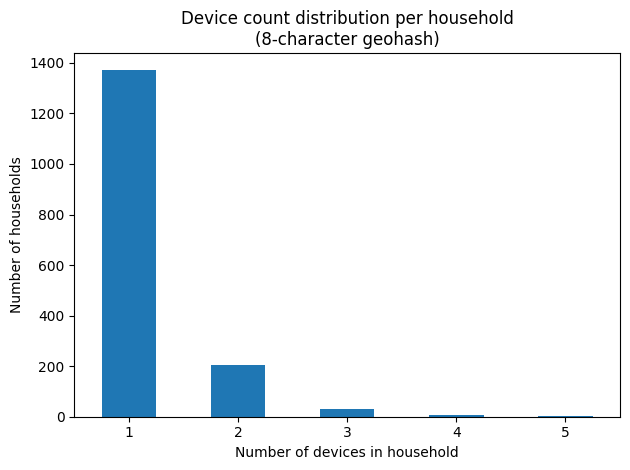

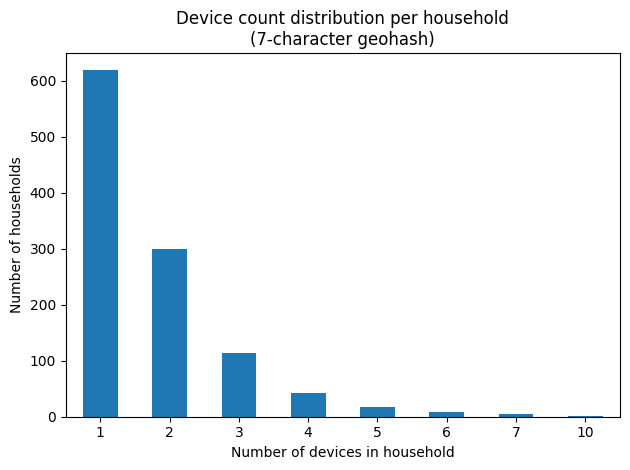

In [26]:
# ------------------------------------------------------------------
# Grab the DataFrame that the user said is already in the workspace
# ------------------------------------------------------------------
result_df_subset["home_geohash_7"] = result_df_subset["home_geohash_8"].str[:7]
df = globals().get("result_df_subset", None)

if df is None:
    raise RuntimeError(
        "I couldn't find `result_df_subset` in the current environment. "
        "Please run the cell that defines it before executing this one."
    )

# ------------------------------------------------------------------
# 1. Distribution using the original 8-character geohash
# ------------------------------------------------------------------
counts8 = (
    df.groupby("home_geohash_8")["device_id"]
      .nunique()
      .rename("num_devices")
)

plt.figure()
(
    counts8.value_counts()
           .sort_index()
           .plot(kind="bar", rot=0)
)
plt.title("Device count distribution per household\n(8-character geohash)")
plt.xlabel("Number of devices in household")
plt.ylabel("Number of households")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------------
# 2. Distribution after truncating to 7 characters
# ------------------------------------------------------------------
df["home_geohash_7"] = df["home_geohash_8"].str[:7]
counts7 = (
    df.groupby("home_geohash_7")["device_id"]
      .nunique()
      .rename("num_devices")
)

plt.figure()
(
    counts7.value_counts()
           .sort_index()
           .plot(kind="bar", rot=0)
)
plt.title("Device count distribution per household\n(7-character geohash)")
plt.xlabel("Number of devices in household")
plt.ylabel("Number of households")
plt.tight_layout()
plt.show()


In [28]:
import itertools

# 1. Build lookup sets: edges with prediction == 1, and those with connection type == 1
connected_pairs = set()
type1_pairs = set()

for u, v, p, ctype in zip(graph_df['user_u'], graph_df['user_v'], graph_df['prediction'], graph_df['connection type']):
    if p == 1:
        edge = tuple(sorted([u, v]))
        connected_pairs.add(edge)
        if ctype == 1:
            type1_pairs.add(edge)

# Total number of type 1 edges (for computing the global share)
total_type1_edges = len(type1_pairs)

# 2. Group by household: get list of devices in each household
household_groups = result_df_subset.groupby('home_geohash_8')['device_id'].apply(list)

# 3. Iterate over each household and compute internal connection stats
total_pairs = 0                    # Total number of device pairs within households
connected_count = 0               # Number of predicted connected pairs
internal_type1_count = 0          # Number of type 1 connections within households

for device_list in household_groups:
    if len(device_list) < 2:
        continue  # Skip households with only one device

    # Enumerate all unordered device pairs within the household
    pairs = itertools.combinations(device_list, 2)
    for u, v in pairs:
        total_pairs += 1
        edge = tuple(sorted([u, v]))
        if edge in connected_pairs:
            connected_count += 1
        if edge in type1_pairs:
            internal_type1_count += 1

# 4. Compute ratios
if total_pairs == 0:
    ratio = float('nan')
    type1_internal_ratio = float('nan')
else:
    ratio = connected_count / total_pairs
    type1_internal_ratio = internal_type1_count / total_pairs

if total_type1_edges == 0:
    type1_share = float('nan')
else:
    type1_share = internal_type1_count / total_type1_edges

# 5. Print results
print(f"Proportion of social connections within the same household: {ratio:.2%} ({connected_count} / {total_pairs})")
print(f"Proportion of bonding connections among all possible within-household device pairs: {type1_internal_ratio:.2%} ({internal_type1_count} / {total_pairs})")
print(f"Proportion of bonding connections that occur within the same household out of all bonding connections: {type1_share:.2%} ({internal_type1_count} / {total_type1_edges})")


Proportion of social connections within the same household: 93.43% (327 / 350)
Proportion of bonding connections among all possible within-household device pairs: 41.71% (146 / 350)
Proportion of bonding connections that occur within the same household out of all bonding connections: 49.32% (146 / 296)


# Household Social Network Construction

In [29]:
import pandas as pd
from itertools import combinations

# --------------------------
# 1. Read the CSV file and generate the individual_links list
# --------------------------
# Keep only user pairs predicted as connected, and extract user_u, user_v, and connection type columns
individual_links = graph_df[['user_u', 'user_v', 'connection type']].values.tolist()
print("Total individual links (predicted connected):", len(individual_links))
print(individual_links)
# --------------------------
# 2. Build a mapping from device to home (home geohash)
# Assume result_df_subset contains columns device_id and home_geohash_8
# --------------------------
device_to_home = result_df_subset.set_index('device_id')['home_geohash_8'].to_dict()

# --------------------------
# 3. Count the number of devices in each home
# --------------------------
home_device_count = result_df_subset['home_geohash_8'].value_counts().to_dict()

# --------------------------
# 4. Traverse individual_links to generate inter-home connection counts
#    Only consider connections between different homes.
#    For each home pair, if there is at least one bonding link (conn_type==1), mark type as 1.
# --------------------------
home_link_counts = {}
for d1, d2, conn_type in individual_links:
    if d1 in device_to_home and d2 in device_to_home:
        h1 = device_to_home[d1]
        h2 = device_to_home[d2]
        if h1 != h2:
            # Ensure consistent order
            home_pair = tuple(sorted([h1, h2]))
            if home_pair not in home_link_counts:
                home_link_counts[home_pair] = {'count': 0, 'type': 0}
            home_link_counts[home_pair]['count'] += 1
            # If at least one bonding link exists, set type to 1
            if conn_type == 1:
                home_link_counts[home_pair]['type'] = 1

# --------------------------
# 5. Generate list of home candidate pairs
# --------------------------
home_candidate_pair = list(home_link_counts.keys())
print("Number of home candidate pairs:", len(home_candidate_pair))

# --------------------------
# 6. Construct home_edges DataFrame and compute avg_link (average connection strength)
#    avg_link = link_count / (number of devices in home 1 + number of devices in home 2)
# --------------------------
home_edges_data = []
for (h1, h2), info in home_link_counts.items():
    link_count = info['count']
    home_type = info['type']
    # Compute the number of possible device pairs (sum of device counts from both homes)
    num_possible = home_device_count.get(h1, 0) * home_device_count.get(h2, 0)
    avg_link = link_count / num_possible if num_possible > 0 else 0
    home_edges_data.append({
        "home_1": h1,
        "home_2": h2,
        "link_count": link_count,
        "num_possible": num_possible,
        "avg_link": avg_link,
        "type": home_type
    })

home_edges = pd.DataFrame(home_edges_data)

# --------------------------
# Output results
# --------------------------
print('How many devices are there in each home:')
print(home_device_count)
print("Home candidate pairs:")
print(home_candidate_pair)


home_edges['home_1_number'] = home_edges['home_1'].map(home_device_count)
home_edges['home_2_number'] = home_edges['home_2'].map(home_device_count)
# Identify all homes and those already in edges
all_homes = set(result_df_subset['home_geohash_8'])
homes_in_edges = set(home_edges['home_1']) | set(home_edges['home_2'])
print('All Household',len(all_homes))
print("Unique Device Id count:", len(result_df_subset))
print('Household that have links:',len(homes_in_edges))
# Find isolated homes (no edges)
isolated_homes = all_homes - homes_in_edges

# Create rows for isolated homes
isolated_rows = []
for h in isolated_homes:
    isolated_rows.append({
        'home_1': h,
        'home_2': None,
        'link_count': None,
        'num_possible': None,
        'avg_link': None,
        'type': None,
        'home_1_number': home_device_count.get(h, None),
        'home_2_number': None
    })

# Append to home_edges
isolated_df = pd.DataFrame(isolated_rows)
home_edges = pd.concat([home_edges, isolated_df], ignore_index=True)

home_edges.to_csv(f"florida_results/Household_social_network_{start_date.date()}.csv", index=False)
home_edges

Total individual links (predicted connected): 17788
[['46919960fe', 'b5fa180dbc', 0], ['61bade66ff', 'afeb7f9f72', 0], ['489ca24b5d', 'e2285236a5', 0], ['724e256c4c', 'b1cce4033f', 0], ['56f72158ce', 'd5dc06e68e', 0], ['1d9a2c5dd4', '54655ebf7f', 0], ['ae0b9ba667', 'dbe8ef0e4d', 0], ['4fd771be68', 'ae8327b163', 0], ['37563eaa3a', '55eead234d', 0], ['26006d9aa5', '9cbae2f3d3', 0], ['371a233822', '7a4e3469e1', 0], ['ba378aabe1', 'f37515dfd7', 0], ['2d9e43946c', '341bdf6ab0', 0], ['08221c48b5', '9076d832ea', 0], ['16c9bc221c', 'e20f722eb6', 0], ['80cba97ee8', '81ac1869e7', 0], ['039be6f30e', 'ff1d44e88f', 0], ['98ad904b57', 'eb76b35a12', 0], ['9cf7009980', 'cf942340c5', 0], ['5528b948e5', '6465d8835a', 0], ['935b22d65d', 'f1f1dda935', 0], ['07ecd0b66a', '44f01e6c1a', 0], ['984f80c7cb', 'f7a81ac9f3', 0], ['2b87b2a254', '914d22ed63', 0], ['bc7624b311', 'ed25f4bd5b', 0], ['d3c2593635', 'f3d06bd992', 0], ['083dcb7624', '09649c6e51', 0], ['4662cc80b7', '67160f4dff', 0], ['58bae0f148', 'bacb1e5

<ipython-input-29-8c2aed8d7a43>:106: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  home_edges = pd.concat([home_edges, isolated_df], ignore_index=True)


,home_1,home_2,link_count,num_possible,avg_link,type,home_1_number,home_2_number
0,dqcn9xvx,dqcnbbpk,1,1,1.0,0,1,1
1,dqc1dj64,dqcp1bry,1,1,1.0,0,1,1
2,dqcnc78w,dqcncjbv,1,2,0.5,0,1,2
3,dqcn9w6w,dqcncty0,1,2,0.5,0,2,1
4,dqcnc8bt,dqcnfps5,1,1,1.0,0,1,1
...,...,...,...,...,...,...,...,...
15677,dqcp5jfz,None,None,None,NaN,None,1,None
15678,dqcnf4cj,None,None,None,NaN,None,2,None
15679,dqcnf4cs,None,None,None,NaN,None,1,None
15680,dqcnf9h5,None,None,None,NaN,None,1,None


# Household Decision State Generation

In [30]:
result_df_subset=pd.read_csv(f'florida_results/user_home_relation_{original_date.date()}.csv')

# 1. Preprocessing: parse time, filter daytime (9–17)
linked_df['timestamp_2'] = pd.to_datetime(linked_df['timestamp_2'])
linked_df['hour'] = linked_df['timestamp_2'].dt.hour
day_df = linked_df[(linked_df['hour'] >= 9) & (linked_df['hour'] < 17)].copy()

# 2. Prepare: home geohash → set of resident devices
home_residents = (
    result_df_subset
    .groupby('home_geohash_8')['device_id']
    .apply(set)
    .to_dict()
)

# Add 7-character geohash to home data
result_df_subset['home_geohash_7'] = result_df_subset['home_geohash_8'].str[:7]

# Extract 7-character geohash from each trajectory point
day_df['geohash_7'] = day_df['geohash_2'].str[:7]

# Merge using 7-character geohash to filter visits near homes
visits = (
    day_df
      .merge(
         result_df_subset[['home_geohash_7','home_geohash_8']],
         left_on='geohash_7', right_on='home_geohash_7',
         how='inner'
      )
      [['home_geohash_8','device_id','timestamp_2']]
)


# ——————————————————————————————————————————————————————————————————————————
# 4. Detect (1) Non-resident temporary visits
#    — If a home has a visiting device not in home_residents on the same day
# ——————————————————————————————————————————————————————————————————————————
def detect_non_resident(
    visits_df: pd.DataFrame,
    home_res_map: dict,
    min_duration_hours: float = 3
) -> pd.DataFrame:
    """
    Keep only non-resident devices that stayed in a home_geohash_8 area
    for at least min_duration_hours within the same day.

    visits_df must contain ['home_geohash_8','device_id','timestamp_2'],
    home_res_map is {home_geohash_8: set(device_id)}.
    """
    # Ensure timestamp column is datetime and extract date
    df = visits_df.copy()
    df['timestamp_2'] = pd.to_datetime(df['timestamp_2'])
    df['date'] = df['timestamp_2'].dt.date

    records = []
    # Group by home
    for home8, grp in tqdm(df.groupby('home_geohash_8')):
        # Filter out non-resident devices
        non_res = grp[~grp['device_id'].isin(home_res_map.get(home8, set()))]
        if non_res.empty:
            continue

        # For each device_id + date, compute duration between first and last visit
        dur = (
            non_res
            .groupby(['device_id','date'])['timestamp_2']
            .agg(start='min', end='max')
            .reset_index()
        )
        dur['duration_h'] = (
            dur['end'] - dur['start']
        ).dt.total_seconds() / 3600.0

        # Keep devices with at least one visit ≥ min_duration_hours
        long_stays = dur[dur['duration_h'] >= min_duration_hours]
        devices = set(long_stays['device_id'])
        if devices:
            records.append({
                'home_geohash_8':    home8,
                'non_resident_count': len(devices),
                'non_residents':     devices
            })

    return pd.DataFrame(records)

def detect_night_absence(
    linked_df: pd.DataFrame,
    result_df_subset: pd.DataFrame,
    night_start: int = 23,
    night_end: int = 6,
    threshold_days: int = 2,
    hash_precision: int = 7
):
    """
    Detect continuous nighttime absence.

    Returns
    -------
    device_absence_df : DataFrame
        Columns: [home_geohash_8, device_id, absent_start_date, absent_end_date]
        Represents periods when a device was absent for threshold_days consecutive nights.

    home_absence_df : DataFrame
        Columns: [home_geohash_8, absent_start_date, absent_end_date]
        Represents periods when all devices in a home were absent during the same window.
    """
    # 1. Copy and parse timestamps, extract hour
    df = linked_df.copy()
    df['timestamp_2'] = pd.to_datetime(df['timestamp_2'])
    df['hour'] = df['timestamp_2'].dt.hour

    # 2. Filter nighttime records and annotate date
    night = df[(df['hour'] >= night_start) | (df['hour'] < night_end)].copy()
    night['date'] = night['timestamp_2'].dt.date

    # 3. Truncate geohash
    df_prefix = f'geo_pref'
    home_prefix = f'home_pref'
    night[df_prefix] = night['geohash_2'].str[:hash_precision]
    homes = result_df_subset[['home_geohash_8','device_id']].copy()
    homes[home_prefix] = homes['home_geohash_8'].str[:hash_precision]

    # 4. Identify nighttime check-ins at home
    at_home = night.merge(
        homes,
        left_on=[df_prefix,'device_id'],
        right_on=[home_prefix,'device_id'],
        how='inner'
    )[['home_geohash_8','device_id','date']]

    # 5. Construct complete list of nighttime dates
    all_dates = pd.date_range(
        night['date'].min(),
        night['date'].max(),
        freq='D'
    ).date

    # 6. Aggregate (home,device) → set of check-in dates
    visited_map = (
        at_home
        .groupby(['home_geohash_8','device_id'])['date']
        .agg(set)
        .to_dict()
    )

    # 7. Device-level: sliding window to find first continuous absence
    device_records = []
    home_residents = homes.groupby('home_geohash_8')['device_id'].apply(set).to_dict()
    for home8, devices in home_residents.items():
        for dev in devices:
            seen = visited_map.get((home8, dev), set())
            for i in range(len(all_dates) - threshold_days + 1):
                window = all_dates[i:i+threshold_days]
                if all(day not in seen for day in window):
                    device_records.append({
                        'home_geohash_8':    home8,
                        'device_id':         dev,
                        'absent_start_date': window[0],
                        'absent_end_date':   window[-1]
                    })
                    break
    device_absence_df = pd.DataFrame(device_records)

    # 8. Home-level: sliding window to find periods when all members are absent
    home_records = []
    for home8, devices in home_residents.items():
        for i in range(len(all_dates) - threshold_days + 1):
            window = all_dates[i:i+threshold_days]
            # Check that all devices in the home were absent in the window
            if all(
                all(day not in visited_map.get((home8, dev), set()) for day in window)
                for dev in devices
            ):
                home_records.append({
                    'home_geohash_8':    home8,
                    'absent_start_date': window[0],
                    'absent_end_date':   window[-1]
                })
                break
    home_absence_df = pd.DataFrame(home_records)

    return device_absence_df, home_absence_df

# — Example Call —
non_resident_visits = detect_non_resident(visits, home_residents)
device_df, home_df = detect_night_absence(linked_df, result_df_subset, night_start = 23, night_end = 6, threshold_days = 15, hash_precision=8)
print('total number of home', len(result_df_subset))

repairs_df = pd.merge(
    non_resident_visits[['home_geohash_8', 'non_resident_count']],
    home_df[['home_geohash_8', 'absent_start_date', 'absent_end_date']],
    on='home_geohash_8',
    how='inner'
)

print("Homes possibly under repair:")
print(repairs_df)
repairs_df.to_csv(f'florida_results/house_reparing{start_date.date()}.csv',index=False)

100%|██████████| 1587/1587 [00:07<00:00, 217.57it/s]


total number of home 1904
Homes possibly under repair:
     home_geohash_8  non_resident_count absent_start_date absent_end_date
0          dqcn3n25                   1        2020-01-01      2020-01-15
1          dqcn7md7                   2        2020-01-01      2020-01-15
2          dqcn7np8                   2        2020-01-09      2020-01-23
3          dqcn9pjm                   3        2020-01-01      2020-01-15
4          dqcn9rqd                   2        2020-01-08      2020-01-22
...             ...                 ...               ...             ...
1007       dqcp62p2                   2        2020-01-01      2020-01-15
1008       dqcp6bnc                   2        2020-01-13      2020-01-27
1009       dqcp6bnw                   2        2020-01-01      2020-01-15
1010       dqcp701g                   1        2020-01-01      2020-01-15
1011       dqcp701n                   1        2020-01-01      2020-01-15

[1012 rows x 4 columns]


In [31]:
from typing import Dict, Set, List, Tuple

# --- tiny, vectorised Haversine helper ------------------------------------------
EARTH_R = 6_371_000.0  # mean Earth radius in metres

def haversine(lat1, lon1, lat2, lon2):
    """Vectorised Haversine distance (metres)."""
    lat1, lon1, lat2, lon2 = map(np.radians, (lat1, lon1, lat2, lon2))
    dlat  = lat2 - lat1
    dlon  = lon2 - lon1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    return 2 * EARTH_R * np.arcsin(np.sqrt(a))

# -------------------------------------------------------------------------------


def detect_rental_homes_medprec(
    linked_df: pd.DataFrame,
    result_df_subset: pd.DataFrame,
    owner_absence_days: int = 7,
    min_strangers: int = 2,
    night_start: int = 0,
    night_end: int = 6,
    dist_threshold_m: float = 60.0,    # spatial radius
    min_stay_hrs: float = 1.0          # stranger must stay ≥ 4 h (cumulative per night)
) -> pd.DataFrame:
    """
    Medium-precision rental detector.

    Stranger condition
    ------------------
    A device counts as a stranger **only if its cumulative dwell time within
    `dist_threshold_m` of the home, *inside the night window*, is ≥ `min_stay_hrs`
    on any one of the checked nights.
    """

    # -------- 1.  Keep only night-time rows --------------------------------------
    df = linked_df.copy()
    df["timestamp_2"] = pd.to_datetime(df["timestamp_2"])
    df["hour"]   = df["timestamp_2"].dt.hour
    df["date"]   = df["timestamp_2"].dt.date

    night_mask   = (df["hour"] >= night_start) | (df["hour"] < night_end)
    cols_keep    = [
        "device_id", "timestamp_2", "geohash_2",
        "date", "latitude_2", "longitude_2"
    ]
    night_df = df.loc[night_mask, cols_keep].copy()
    night_df["gh5"] = night_df["geohash_2"].str[:5]   # for owner
    night_df["gh6"] = night_df["geohash_2"].str[:6]   # coarse stranger filter

    # -------- 2.  Home / owner tables -------------------------------------------
    homes = result_df_subset[
        ["home_geohash_8", "device_id", "home_latitude", "home_longitude"]
    ].copy()
    homes["home5"] = homes["home_geohash_8"].str[:5]
    homes["home6"] = homes["home_geohash_8"].str[:6]

    home_to_owners: Dict[str, Set[str]] = (
        homes.groupby("home_geohash_8")["device_id"].apply(set).to_dict()
    )

    # -------- 3.  Recent nights --------------------------------------------------
    night_dates: List[pd.Timestamp] = sorted(night_df["date"].unique())
    if len(night_dates) < owner_absence_days:
        raise ValueError("Not enough days of data")

    recent_nights = set(night_dates[-owner_absence_days:])
    night_recent  = night_df.loc[night_df["date"].isin(recent_nights)].copy()

    # -------- 4.  Owner absence --------------------------------------------------
    owners_at_night = (
        night_recent.merge(
            homes[["home_geohash_8", "device_id", "home5"]],
            left_on=["device_id", "gh5"],
            right_on=["device_id", "home5"],
            how="inner",
        )[["home_geohash_8", "date"]]
        .drop_duplicates()
    )

    seen_dates: Dict[str, Set[pd.Timestamp]] = (
        owners_at_night.groupby("home_geohash_8")["date"].apply(set).to_dict()
    )

    absent_homes = {
        h: sorted(recent_nights - seen_dates.get(h, set()))
        for h in home_to_owners
        if len(recent_nights - seen_dates.get(h, set())) == owner_absence_days
    }

    # -------- 5.  Stranger presence ≥ x hour ---------------------------------------
    gh6_groups: Dict[str, pd.DataFrame] = dict(tuple(night_recent.groupby("gh6")))

    rental_candidates = []
    four_hours = timedelta(hours=min_stay_hrs)

    for home8, absent_dates in tqdm(absent_homes.items()):
        owners = home_to_owners[home8]
        row    = homes.loc[homes["home_geohash_8"] == home8].iloc[0]
        hlat, hlon = row["home_latitude"], row["home_longitude"]
        h6         = row["home6"]

        # 5-A coarse gh6 filter
        if h6 not in gh6_groups:
            continue
        df_candidates = gh6_groups[h6]

        # 5-B precise radius filter
        dists = haversine(
            hlat, hlon,
            df_candidates["latitude_2"].values,
            df_candidates["longitude_2"].values,
        )
        close_df = df_candidates.loc[dists <= dist_threshold_m]

        # 5-C dwell-time per stranger, night by night
        #     group → (device, date)  so we can accumulate **within one night**
        grouped = close_df.groupby(["device_id", "date"])

        long_stayers: Set[str] = set()
        for (dev, day), sub in grouped:
            if dev in owners:
                continue
            # sort by time to avoid negative spans if timestamps unordered
            span = sub["timestamp_2"].sort_values()
            dwell = span.max() - span.min()
            if dwell >= four_hours:
                long_stayers.add(dev)

        if len(long_stayers) >= min_strangers:
            rental_candidates.append(
                {
                    "home_geohash_8":    home8,
                    "owner_absent_dates": absent_dates,

                }
            )

    return pd.DataFrame(rental_candidates)
# ---------------- Example ---------------------------------------------------------
sold_df = detect_rental_homes_medprec(
    linked_df,
    result_df_subset,
    owner_absence_days=7,
    min_strangers=1,
    night_start=21,
    night_end=8
)
print('House possibily sold:')
print(sold_df)

sold_df.to_csv(f'florida_results/Sold_house{start_date.date()}.csv',index=False)

100%|██████████| 456/456 [00:01<00:00, 302.14it/s]


House possibily sold:
   home_geohash_8                                 owner_absent_dates
0        dqcn8zk3  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
1        dqcn9ks8  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
2        dqcnbbdt  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
3        dqcnbbdu  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
4        dqcncb29  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
5        dqcncfmf  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
6        dqcncfne  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
7        dqcncfyx  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
8        dqcncs1r  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
9        dqcncs3d  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
10       dqcncssg  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
11       dqcncstv  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
12       dqcnct64  [2020-01-27, 2020-01-28, 2020-01-29, 2020-01-3...
13       dqc

In [32]:
def detect_moved(
    linked_df: pd.DataFrame,
    result_df_subset: pd.DataFrame,
    min_lat: float,
    max_lat: float,
    min_lon: float,
    max_lon: float,
    days_threshold: int = 30
):
    """
    Detect moved devices/households:
      - Device level: If a device_id hasn't entered the specified region for more than days_threshold days,
        it's considered as moved.
      - Household level: If all devices in a household are considered moved, then the household is considered fully moved.

    Parameters
    ----------
    linked_df : DataFrame
        Raw trajectory data, must contain ['device_id','latitude_2','longitude_2','timestamp_2']
    result_df_subset : DataFrame
        Home-device mapping, must contain ['home_geohash_8','device_id']
    min_lat, max_lat, min_lon, max_lon : float
        Geographic boundaries of the target region
    days_threshold : int
        Threshold in days for absence from the region (default is 30)

    Returns
    -------
    moved_devices_df : DataFrame
        columns = [
          'device_id',
          'last_in_region_date',   # Date of last visit inside region
          'days_since_last'        # Days since that date to the latest date in dataset
        ]
    moved_households_df : DataFrame
        columns = [
          'home_geohash_8',
          'total_devices',
          'moved_device_count'
        ]
        Only includes households where all devices are considered moved
    """
    # 1. Parse timestamp and extract date
    df = linked_df.copy()
    df['timestamp_2'] = pd.to_datetime(df['timestamp_2'])
    df['date'] = df['timestamp_2'].dt.date

    # 2. Get the latest date in the dataset
    overall_max = df['date'].max()

    # 3. Filter records within the specified region
    mask = (
        (df['latitude_2']  >= min_lat ) & (df['latitude_2']  <= max_lat) &
        (df['longitude_2'] >= min_lon ) & (df['longitude_2'] <= max_lon)
    )
    in_region = df[mask]

    # 4. Device-level: compute last date in region & days since then
    records_dev = []
    for dev, grp in in_region.groupby('device_id'):
        last_date = grp['date'].max()
        days_since = (overall_max - last_date).days
        if days_since > days_threshold:
            records_dev.append({
                'device_id':           dev,
                'last_in_region_date': last_date,
                'days_since_last':     days_since
            })
    moved_devices_df = pd.DataFrame(records_dev)

    # 5. Household-level: count how many homes have all devices moved
    home_devs = (
        result_df_subset
        .groupby('home_geohash_8')['device_id']
        .apply(list)
        .to_dict()
    )
    if moved_devices_df.empty:
      return moved_devices_df, moved_devices_df

    moved_set = set(moved_devices_df['device_id'])
    records_home = []
    for home, devices in home_devs.items():
        total = len(devices)
        moved_cnt = sum(1 for d in devices if d in moved_set)
        if moved_cnt == total and total > 0:
            records_home.append({
                'home_geohash_8':      home,
                'total_devices':       total,
                'moved_device_count':  moved_cnt
            })
    moved_households_df = pd.DataFrame(records_home)

    return moved_devices_df, moved_households_df


moved_devs, moved_homes = detect_moved(
    linked_df,
    result_df_subset,
    min_lat, max_lat, min_lon, max_lon,
    days_threshold=15
)


print("Households where all members moved:")
print(moved_homes)
moved_homes.to_csv(f'florida_results/Migrated_home{start_date.date()}.csv',index=False)

Households where all members moved:
  home_geohash_8  total_devices  moved_device_count
0       dqcn70wr              1                   1
1       dqcngkv3              1                   1


In [33]:
def detect_vacant(
    linked_df: pd.DataFrame,
    mapping_df: pd.DataFrame,
    min_lat: float,
    max_lat: float,
    min_lon: float,
    max_lon: float,
    days_threshold: int = 30,
    geohash_precision: int = 8,
) -> pd.DataFrame:
    """
    A home is vacant when *at least one* of its devices has been observed
    at the exact home geohash, and **all** such devices have been absent for
    > `days_threshold` days.

    Homes whose devices never appear at home at all are ignored (not classed
    as vacant or occupied).
    """
    if linked_df.empty:
        return pd.DataFrame()

    df = linked_df.copy()
    df["timestamp_2"] = pd.to_datetime(df["timestamp_2"])
    df["date"] = df["timestamp_2"].dt.date
    overall_max = df["date"].max()

    # bounding box filter
    region_mask = (
        (df["latitude_2"] >= min_lat)
        & (df["latitude_2"] <= max_lat)
        & (df["longitude_2"] >= min_lon)
        & (df["longitude_2"] <= max_lon)
    )
    region_df = df[region_mask]

    # attach home id
    region_df = region_df.merge(
        mapping_df[["device_id", "home_geohash_8"]],
        on="device_id",
        how="inner",
    )

    # encode track geohash and flag at_home rows
    region_df["track_geohash"] = region_df.apply(
        lambda r: pgh.encode(
            r["latitude_2"], r["longitude_2"], precision=geohash_precision
        ),
        axis=1,
    )
    region_df["at_home"] = region_df["track_geohash"] == region_df["home_geohash_8"]

    # last seen at home per device
    dev_last_seen = (
        region_df[region_df["at_home"]]
        .groupby("device_id")["date"]
        .max()
    )

    # build vacancy list
    home_records = []
    for home, devs in (
        mapping_df.groupby("home_geohash_8")["device_id"].apply(list).items()
    ):
        # consider only devices that have ever been at_home
        devs_with_visits = [d for d in devs if d in dev_last_seen]
        if not devs_with_visits:
            continue  # ignore homes never observed at home

        gaps = [(overall_max - dev_last_seen[d]).days for d in devs_with_visits]
        if all(g > days_threshold for g in gaps):
            home_records.append(
                {
                    "home_geohash_8": home,
                    "last_seen_date": max(dev_last_seen[d] for d in devs_with_visits),
                    "days_since_last_seen": max(gaps),
                    "total_devices": len(devs_with_visits),
                }
            )

    return pd.DataFrame(home_records)


vacant_df = detect_vacant(
        linked_df,
        result_df_subset,
        min_lat, max_lat, min_lon, max_lon,
        days_threshold=20
    )
print("Households that are vacant:")
print(vacant_df)
vacant_df.to_csv(f'florida_results/Vacant_home{start_date.date()}.csv',index=False)

Households that are vacant:
    home_geohash_8 last_seen_date  days_since_last_seen  total_devices
0         dqcn9xuy     2020-01-12                    21              1
1         dqcn9xvx     2020-01-12                    21              1
2         dqcnbbvn     2020-01-05                    28              1
3         dqcnbc79     2020-01-12                    21              1
4         dqcnbfk4     2020-01-12                    21              1
..             ...            ...                   ...            ...
97        dqcp4jk6     2020-01-11                    22              1
98        dqcp4kb6     2020-01-04                    29              1
99        dqcp4kcd     2020-01-11                    22              1
100       dqcp4nfx     2020-01-12                    21              1
101       dqcp52kb     2020-01-11                    22              1

[102 rows x 4 columns]


# Household States Visulization

florida_results/Migrated_home2022-08-01.csv
florida_results/Vacant_home2022-08-01.csv
[{'date': Timestamp('2022-08-01 00:00:00'), 'status': 'Migrated', 'count': 2}, {'date': Timestamp('2022-08-01 00:00:00'), 'status': 'Vacant', 'count': 102}]


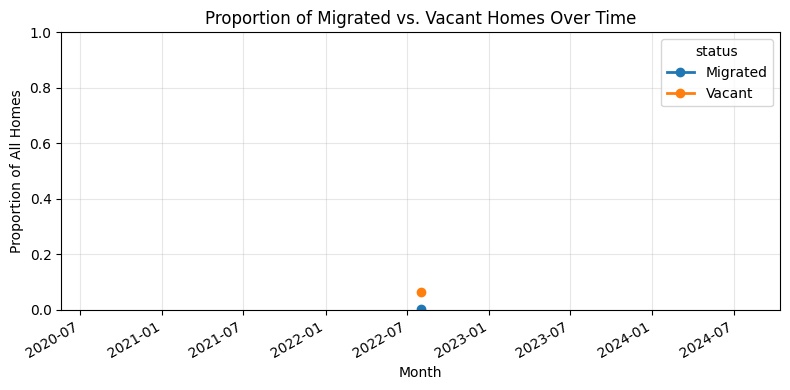

In [34]:
def plot_home_status_ratio_trend(
    folder: str = "",
    migrated_pattern: str = "Migrated_home*.csv",
    vacant_pattern: str = "Vacant_home*.csv",
    total_households: int = None
) -> pd.DataFrame:
    """
    Read Migrated_home*.csv and Vacant_home*.csv, compute monthly proportions
    of each status among all households, and plot the trend.

    Parameters
    ----------
    folder : str
        Directory containing the CSV files.
    migrated_pattern : str
        Filename pattern for migrated home CSVs.
    vacant_pattern : str
        Filename pattern for vacant home CSVs.
    total_households : int
        Total number of households. If None, auto-calculated from all unique home_geohash_8 values.

    Returns
    -------
    ratio_df : pd.DataFrame
        Index: dates; Columns: ['Migrated', 'Vacant']; Values: proportions (0 to 1).
    """
    status_patterns = {
        "Migrated": migrated_pattern,
        "Vacant": vacant_pattern,
    }

    # Step 1: Read all status files and count unique homes
    records = []
    all_home_ids = set()
    for status, pattern in status_patterns.items():
        for file_path in sorted(Path(folder).glob(pattern)):
            print(file_path)
            date_str = file_path.stem.split("home")[-1]  # e.g. "2019-01-01"
            date = pd.to_datetime(date_str)
            df = pd.read_csv(file_path)
            home_ids = df["home_geohash_8"].unique()
            count = len(home_ids)
            records.append({
                "date": date,
                "status": status,
                "count": count
            })
            all_home_ids.update(home_ids)
    print(records)
    trend_df = (
        pd.DataFrame(records)
        .pivot(index="date", columns="status", values="count")
        .sort_index()
    )

    # Step 2: Determine total households
    if total_households is None:
        total_households = len(all_home_ids)

    # Step 3: Compute proportions
    ratio_df = trend_df.div(total_households)

    # Step 4: Plot
    plt.figure(figsize=(8, 4))
    ratio_df.plot(marker="o", linewidth=2, ax=plt.gca())
    plt.title("Proportion of Migrated vs. Vacant Homes Over Time")
    plt.xlabel("Month")
    plt.ylabel("Proportion of All Homes")
    plt.ylim(0, 1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig('states_change.png')
    plt.show()

    return ratio_df

num_unique_homes = result_df_subset['home_geohash_8'].nunique()
ratio_df = plot_home_status_ratio_trend(migrated_pattern="florida_results/Migrated_home*.csv", vacant_pattern= "florida_results/Vacant_home*.csv", total_households=num_unique_homes)

In [36]:

# ────────────────────────────────────────────────────────────
df_edges_original = pd.read_csv('florida_results/Household_social_network_2022-08-01.csv')
home_device_count = {}
for _, row in df_edges_original.iterrows():
    home_device_count[row['home_1']] = row['home_1_number']
    home_device_count[row['home_2']] = row['home_2_number']

# Method 2: pandas concat
s1 = (
    df_edges_original[['home_1', 'home_1_number']]
    .drop_duplicates()
    .set_index('home_1')['home_1_number']
)
s2 = (
    df_edges_original[['home_2', 'home_2_number']]
    .drop_duplicates()
    .set_index('home_2')['home_2_number']
)
home_device_count = pd.concat([s1, s2]).to_dict()

# ────────────────────────────────────────────────────────────

# ───────────── 1. Decode all household nodes (Geohash→Lat/Lon) ─────────────
all_home_geohashes = pd.unique(df_edges_original[['home_1', 'home_2']].values.ravel('K'))
print('Number of Household Nodes:', len(all_home_geohashes))
home_centers_data = []
for hid in all_home_geohashes:
    try:
        lat, lon = pgh.decode(hid)
        home_centers_data.append({
            "home_geohash_8": hid,
            "home_latitude":  lat,
            "home_longitude": lon
        })
    except Exception as e:
        print(f"Failed to decode '{hid}': {e}")

home_centers = pd.DataFrame(home_centers_data)

# ───────────── Bounding Area ─────────────

south = min_lat
north = max_lat
west =  min_lon
east =  max_lon

home_centers = home_centers[
    (home_centers['home_latitude' ].between(south, north)) &
    (home_centers['home_longitude'].between(west,  east ))
].reset_index(drop=True)

# Generate dictionary & device count
home_center_dict  = dict(zip(home_centers['home_geohash_8'],
                             zip(home_centers['home_latitude'],
                                 home_centers['home_longitude'])))

# ───────────── 3. Filter edges: keep only if both ends are inside bounding box ─────────────
valid_nodes = set(home_centers['home_geohash_8'])

# --- Optional: sample to reduce density before or after this point
bridging_keep_fraction = 1
bonding_keep_fraction  = 1

df_edges_bridging = df_edges_original[df_edges_original['type'] == 0]
df_edges_bonding  = df_edges_original[df_edges_original['type'] == 1]

df_edges_bridging = df_edges_bridging.sample(frac=bridging_keep_fraction,
                                             random_state=42)
df_edges_bonding  = df_edges_bonding.sample(frac=bonding_keep_fraction,
                                             random_state=42)

df_edges_filtered = pd.concat([df_edges_bridging, df_edges_bonding], ignore_index=True)

# → Keep only edges where both nodes are valid
df_edges_filtered = df_edges_filtered[
    df_edges_filtered['home_1'].isin(valid_nodes) &
    df_edges_filtered['home_2'].isin(valid_nodes)
].reset_index(drop=True)

print(f"Edge count: {len(df_edges_original)}")
print(f"  - Bridging (Type 0): {len(df_edges_bridging)}")
print(f"  - Bonding (Type 1): {len(df_edges_bonding)}")

# ───────────── 4. Draw the map ─────────────
m = folium.Map(location=[(south+north)/2, (west+east)/2],
               zoom_start=10, tiles='CartoDB positron',
               control_scale=True)

# CSS: center and enlarge scale font
css = """
<style>
  .leaflet-bottom.leaflet-left .leaflet-control-scale {
    left: 50% !important; transform: translateX(-50%)!important;
    font-size:25pt;
  }
  .leaflet-control-scale-line { width: 200px !important; }
</style>
"""
m.get_root().html.add_child(Element(css))

# MiniMap & Mouse coordinates
MiniMap(toggle_display=True, position='bottomright').add_to(m)
MousePosition(position='topright', separator=' ',
              prefix='Coordinates', num_digits=5).add_to(m)

# —— Nodes
for hid, (lat, lon) in home_center_dict.items():
    cnt = home_device_count.get(hid, 1)
    folium.CircleMarker(
        location=[lat, lon],
        radius=3 + cnt * 2,
        color='navy', fill=True, fill_color='cyan', fill_opacity=0.6,
        popup=f"Home: {hid}<br>Devices: {cnt}<br>({lat:.5f}, {lon:.5f})"
    ).add_to(m)

# —— Edges
edge_scale = 1
for _, row in df_edges_filtered.iterrows():
    h1, h2 = row['home_1'], row['home_2']
    p1, p2 = home_center_dict[h1], home_center_dict[h2]
    color = 'darkgreen' if row['type'] == 1 else 'crimson'
    folium.PolyLine(
        [p1, p2],
        weight=max(3, row['avg_link'] * edge_scale),
        color=color, opacity=0.7,
        popup=f"{h1} ↔ {h2}<br>avg_link: {row['avg_link']:.2f}"
    ).add_to(m)

# —— Legend
legend_html = """
<div style="
    position: fixed; bottom: 730px; left: 10px; width: 200px;
    padding: 10px; border: 2px solid gray; background: white;
    z-index:9999; font-size:20px;">
  <div style="margin-bottom:6px;">
    <i style="background:cyan;border:2px solid navy;border-radius:50%;
              width:12px;height:12px;display:inline-block;margin-right:6px;"></i>
    Household node
  </div>
  <div style="margin-bottom:6px;">
    <svg width="20" height="6" style="vertical-align:middle;margin-right:6px;">
      <line x1="0" y1="3" x2="20" y2="3" style="stroke:crimson;stroke-width:3"/>
    </svg>
    Bridging links
  </div>
  <div>
    <svg width="20" height="6" style="vertical-align:middle;margin-right:6px;">
      <line x1="0" y1="5" x2="20" y2="3" style="stroke:darkgreen;stroke-width:3"/>
    </svg>
    Bonding links
  </div>
</div>
"""
m.get_root().html.add_child(Element(legend_html))

LayerControl(collapsed=True).add_to(m)

outfile = 'florida_results/network_map_clipped.html'
m.save(outfile)
print(f"✅ Map saved to {outfile}")
m


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import glob
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.lines import Line2D
def load_edges_by_month(edge_pattern: str):
    """Return {date -> edge-DF} where edge files are named like
       Household_social_network_2019-01-01.csv"""
    edge_dict = {}
    for fp in sorted(glob.glob(edge_pattern)):
        date_str = Path(fp).stem.split('_')[-1]          # "2019-01-01"
        date = pd.to_datetime(date_str)
        edge_dict[date] = pd.read_csv(fp)
    return edge_dict

def build_node_info(df_edges):
    """
    Return (home_center_dict, home_device_count) for a single month.

    - Skips NaN values in home_2.
    - Merges the *_number columns into one device-count dictionary.
    """
    # ---------------- 1. Collect node IDs ----------------
    nodes = pd.unique(
        pd.concat([df_edges['home_1'], df_edges['home_2']])
          .dropna()                             # drop NaN rows
    )

    # ---------------- 2. Geohash → (lat, lon) ----------------
    centers = {
        h: geohash.decode(h) for h in nodes if isinstance(h, str) and h.strip()
    }

    # ---------------- 3. Device counts per node ----------------
    s1 = (df_edges[['home_1', 'home_1_number']]
          .dropna(subset=['home_1'])            # keep rows with a home_1 id
          .drop_duplicates()
          .set_index('home_1')['home_1_number'])

    s2 = (df_edges[['home_2', 'home_2_number']]
          .dropna(subset=['home_2'])            # drop NaN home_2 rows
          .drop_duplicates()
          .set_index('home_2')['home_2_number'])

    counts = pd.concat([s1, s2]).to_dict()

    return centers, counts

def animate_status_over_time_dynamic(
    edge_pattern: str,
    migrated_pattern: str,
    vacant_pattern: str,
    out_gif: str = "network_status.gif",
    base_size: float = 20.0,
    size_scale: float = 5.0,
    interval_ms: int = 1000,
    bridging_keep_fraction: float = 0.01,   # <── NEW
    bonding_keep_fraction:  float = 1.0    # <── NEW
):
    # ───────── 1. Load per-month data ─────────
    edge_dict = load_edges_by_month(edge_pattern)

    def load_status(pattern):
        d = {}
        for fp in sorted(glob.glob(pattern)):
            date_str = Path(fp).stem.split("home")[-1].lstrip("_")
            date = pd.to_datetime(date_str)
            homes = pd.read_csv(fp)["home_geohash_8"].unique()
            d[date] = set(homes)
        return d
    mig_dict = load_status(migrated_pattern)
    vac_dict = load_status(vacant_pattern)

    months = sorted(edge_dict)              # timeline
    if not months:
        raise ValueError("No edge files found.")

    # ───────── 2. Build figure (axes cleared every frame) ─────────
    fig, ax = plt.subplots(figsize=(10, 8))

    # Custom legend (fixed)
    legend_items = [
        Line2D([0], [0], color="crimson",  lw=2, label="Bridging links"),
        Line2D([0], [0], color="darkgreen",lw=2, label="Bonding links"),
        Line2D([0], [0], marker="o", color="black",
               markerfacecolor="navy",   markersize=8, label="Normal"),
        Line2D([0], [0], marker="o", color="black",
               markerfacecolor="red",    markersize=8, label="Migrated"),
        Line2D([0], [0], marker="o", color="black",
               markerfacecolor="orange", markersize=8, label="Vacant")
    ]

    def update(frame_idx):
        date   = months[frame_idx]
        df_e   = edge_dict[date]
        if bridging_keep_fraction < 1.0 or bonding_keep_fraction < 1.0:
            bri = df_e[df_e['type'] == 0]      # bridging
            bon = df_e[df_e['type'] == 1]      # bonding
            if bridging_keep_fraction < 1.0 and len(bri):
                bri = bri.sample(
                    frac=bridging_keep_fraction, random_state=42)
            if bonding_keep_fraction < 1.0 and len(bon):
                bon = bon.sample(
                    frac=bonding_keep_fraction,  random_state=42)
            df_e = pd.concat([bri, bon], ignore_index=True)
        center, counts = build_node_info(df_e)
        # ---------- bounding-box filter ----------
        center = {
            h: (lat, lon) for h, (lat, lon) in center.items()
            if south <= lat <= north and west <= lon <= east
        }
        df_e = df_e[
            df_e['home_1'].isin(center) &
            (df_e['home_2'].isna() | df_e['home_2'].isin(center))
        ].reset_index(drop=True)
        mig_set = mig_dict.get(date, set())
        vac_set = vac_dict.get(date, set())

        ax.cla()
        ax.set_title(f"Migration & Vacancy   {date:%Y-%m}", fontsize=18)
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

        # -------- draw edges (ignore NaN home_2) --------
        for _, row in df_e.iterrows():
            if pd.isna(row['home_2']):          # <── NEW guard
                continue                        # skip “edge” with no target
            lat1, lon1 = center[row['home_1']]
            lat2, lon2 = center[row['home_2']]
            col = "crimson" if row['type'] == 0 else "darkgreen"
            ax.plot([lon1, lon2], [lat1, lat2], color=col, alpha=0.6, lw=1)

        # -------- draw nodes (all centres, incl. isolated) --------
        xs, ys, sizes, cols = [], [], [], []
        for hid, (lat, lon) in center.items():
            xs.append(lon)
            ys.append(lat)
            sizes.append(base_size + size_scale * counts.get(hid, 1))
            if hid in mig_set:       cols.append("red")
            elif hid in vac_set:     cols.append("orange")
            else:                    cols.append("navy")
        ax.scatter(xs, ys, s=sizes, c=cols, edgecolors="black", alpha=0.8)

        ax.legend(handles=legend_items, loc="upper right")
        return []

    anim = FuncAnimation(
        fig, update, frames=len(months),
        interval=interval_ms, repeat=True, blit=False
    )

    # ───────── 3. Save ─────────
    if out_gif.lower().endswith(".gif"):
        anim.save(out_gif, writer="pillow", dpi=120)
    else:
        anim.save(out_gif, writer="ffmpeg", dpi=120)

    plt.close(fig)
    print(f"✅ Saved animation to {out_gif}")

animate_status_over_time_dynamic(
    edge_pattern="florida_results/Household_social_network_*.csv",
    migrated_pattern="florida_results/Migrated_home*.csv",
    vacant_pattern="florida_results/Vacant_home*.csv",
    out_gif="florida_results/network_status.gif",
    base_size=30,
    size_scale=10,
    interval_ms=1000
)

✅ Saved animation to network_status.gif
